# Data Generation Demo

Demonstrating how to generate a dataset using this codebase.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import csv

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog

In [2]:
best_agent = PIDAgent()

best_params = {'steps_u':10, 'scaling_factor':0, 'window_distance':1000} # window distance 1000 to turn off safety leash

In [3]:
env_selector = OctorotorEnvSelector()
squareCW = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]]) # you will need to define a circle trajectory the same way
squareCCW = np.array([[0,100,30], [100,100,30], [100,0,30], [0,0,30]])
circleCCW = np.array([[0.0, 1.2246467991473532e-14, 30.0],
[1.0178558119067134, -14.231483827328493, 30.0],
[4.0507026385502485, -28.17325568414294, 30.0],
[9.03680046454815, -41.541501300188614, 30.0],
[15.874646716881884, -54.064081745559754, 30.0],
[24.425042564574156, -65.4860733945285, 30.0],
[34.51392660547148, -75.57495743542582, 30.0],
[45.93591825444025, -84.12535328311812, 30.0],
[58.458498699811365, -90.96319953545185, 30.0],
[71.82674431585703, -95.94929736144974, 30.0],
[85.76851617267148, -98.98214418809327, 30.0],
[99.99999999999999, -100.0, 30.0],
[114.23148382732849, -98.98214418809329, 30.0],
[128.17325568414293, -95.94929736144975, 30.0],
[141.5415013001886, -90.96319953545185, 30.0],
[154.06408174555972, -84.12535328311814, 30.0],
[165.48607339452855, -75.57495743542582, 30.0],
[175.5749574354258, -65.48607339452856, 30.0],
[184.1253532831181, -54.06408174555975, 30.0],
[190.96319953545185, -41.54150130018864, 30.0],
[195.94929736144974, -28.17325568414298, 30.0],
[198.9821441880933, -14.231483827328532, 30.0],
[200.0, -2.4492935982947064e-14, 30.0],
[198.9821441880933, 14.23148382732848, 30.0],
[195.94929736144974, 28.17325568414293, 30.0],
[190.96319953545182, 41.54150130018868, 30.0],
[184.12535328311816, 54.06408174555971, 30.0],
[175.5749574354258, 65.48607339452852, 30.0],
[165.48607339452855, 75.57495743542579, 30.0],
[154.06408174555975, 84.12535328311812, 30.0],
[141.54150130018866, 90.96319953545184, 30.0],
[128.173255684143, 95.94929736144974, 30.0],
[114.23148382732853, 98.98214418809327, 30.0],
[100.00000000000003, 100.0, 30.0],
[85.76851617267153, 98.98214418809329, 30.0],
[71.82674431585707, 95.94929736144975, 30.0],
[58.45849869981133, 90.96319953545182, 30.0],
[45.9359182544403, 84.12535328311816, 30.0],
[34.51392660547148, 75.57495743542582, 30.0],
[24.425042564574227, 65.48607339452856, 30.0],
[15.874646716881884, 54.064081745559754, 30.0],
[9.036800464548136, 41.54150130018857, 30.0],
[4.050702638550263, 28.17325568414299, 30.0],
[1.0178558119067418, 14.231483827328631, 30.0],
[0.0, 3.6739403974420595e-14, 30.0]])
circleCW = np.array([[0.0, 3.6739403974420595e-14, 30.0],
[1.0178558119067418, 14.231483827328631, 30.0],
[4.050702638550263, 28.17325568414299, 30.0],
[9.036800464548207, 41.541501300188735, 30.0],
[15.874646716881884, 54.064081745559754, 30.0],
[24.425042564574227, 65.48607339452856, 30.0],
[34.51392660547148, 75.57495743542582, 30.0],
[45.9359182544403, 84.12535328311816, 30.0],
[58.45849869981133, 90.96319953545182, 30.0],
[71.82674431585707, 95.94929736144975, 30.0],
[85.76851617267153, 98.98214418809329, 30.0],
[100.00000000000003, 100.0, 30.0],
[114.23148382732853, 98.98214418809327, 30.0],
[128.173255684143, 95.94929736144974, 30.0],
[141.54150130018866, 90.96319953545184, 30.0],
[154.06408174555975, 84.12535328311812, 30.0],
[165.48607339452855, 75.57495743542579, 30.0],
[175.5749574354258, 65.48607339452852, 30.0],
[184.12535328311816, 54.06408174555971, 30.0],
[190.96319953545185, 41.5415013001886, 30.0],
[195.94929736144974, 28.17325568414293, 30.0],
[198.9821441880933, 14.23148382732848, 30.0],
[200.0, -2.4492935982947064e-14, 30.0],
[198.9821441880933, -14.231483827328532, 30.0],
[195.94929736144974, -28.17325568414298, 30.0],
[190.9631995354518, -41.54150130018872, 30.0],
[184.1253532831181, -54.06408174555975, 30.0],
[175.5749574354258, -65.48607339452856, 30.0],
[165.48607339452855, -75.57495743542582, 30.0],
[154.06408174555972, -84.12535328311814, 30.0],
[141.5415013001886, -90.96319953545185, 30.0],
[128.17325568414293, -95.94929736144975, 30.0],
[114.23148382732849, -98.98214418809329, 30.0],
[99.99999999999999, -100.0, 30.0],
[85.76851617267148, -98.98214418809327, 30.0],
[71.82674431585703, -95.94929736144974, 30.0],
[58.458498699811365, -90.96319953545185, 30.0],
[45.93591825444025, -84.12535328311812, 30.0],
[34.51392660547144, -75.57495743542579, 30.0],
[24.42504256457414, -65.48607339452846, 30.0],
[15.874646716881855, -54.06408174555972, 30.0],
[9.03680046454815, -41.541501300188614, 30.0],
[4.0507026385502485, -28.17325568414294, 30.0],
[1.0178558119067134, -14.231483827328493, 30.0],
[0.0, 1.2246467991473532e-14, 30.0]])

In [13]:
def run_trajectory(env_selector, wind_ranges, agent, params, speed, trajectory):
    env = env_selector.get_env("sliding", params, wind_ranges, trajectory, start_alt=30, has_turbulence=True)
    
    env.base_env.vehicle.mass = np.random.normal(10.33, 0.75) # randomly sample a mass - this seems like a reasonable distribution
    env.base_env.ctrl.ctrl_p.max_velocity = speed
    
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    motor_speeds = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        motor_speeds.append(log.vehicle.speeds)

    log.done_logging()
    return log, info, motor_speeds

`wind_ranges` will sample wind in a certain range:
- ex: [(0,5),(0,5),(0,0)] will sample 0-5 m/s in x, 0-5m/s in y, and 0 in z

If you want to fix the wind, you will need to pass something like  [(5,5),(0,0),(0,0)] for 5 m/s east wind or  [(0,0),(-5,-5),(0,0)] for 5 m/s south wind. The function below should be appropriate.

In [5]:
def sample_wind_range(magnitude):
    random_angle_degrees = np.random.uniform(0, 360)

    # Step 2: Convert the angle to radians
    random_angle_radians = np.deg2rad(random_angle_degrees)
    
    # Step 3: Calculate the components of the unit vector
    x_component = np.cos(random_angle_radians)
    y_component = np.sin(random_angle_radians)
    
    # Step 4: Create the unit vector
    unit_vector = np.array([x_component, y_component]) 
    wind_vector = unit_vector * magnitude

    wind_range = [(wind_vector[0], wind_vector[0]), (wind_vector[1], wind_vector[1]), (0,0)]
    return wind_range, wind_vector

In [6]:
sample_wind_range(3)

([(2.679909752331656, 2.679909752331656),
  (1.348363348418252, 1.348363348418252),
  (0, 0)],
 array([2.67990975, 1.34836335]))

In [14]:
wind_range, wind_vector = sample_wind_range(5)
log, info, motor_speeds = run_trajectory(env_selector, wind_range, best_agent, best_params, 10, circleCCW)

-2.598259568599193
-2.598259568599193
-2.598259568599193
-2.598259568599193
-2.598259568599193
-2.3434595827184412
-2.3486330980625456
-2.3628662565595415
-2.360798760882614
-2.367066659451831
-2.346571398163961
-2.3309031458580995
-2.339333890952162
-2.3463697817153712
-2.346608009659688
-2.363340365862641
-2.383290873091748
-2.384865454540403
-2.396408836083305
-2.368123342077269
-2.386901966931912
-2.394476051253719
-2.3572891540823067
-2.3535716489496874
-2.326512358915878
-2.349318131363335
-2.2990338462716986
-2.2357753547737773
-2.205189140686999
-2.2070747570816316
-2.2086950389973925
-2.1787385732794093
-2.190455486918726
-2.1542024634407517
-2.1494756756593727
-2.2337716536667185
-2.309202994071458
-2.349518703755751
-2.413514775170746
-2.4043704379539568
-2.4456955994599587
-2.4742189172533937
-2.45650502685902
-2.491384901518014
-2.470886761521582
-2.5055180944715874
-2.50042971537405
-2.4850698682892505
-2.49329215273219
-2.5609773832848286
-2.5632098629243494
-2.560391128

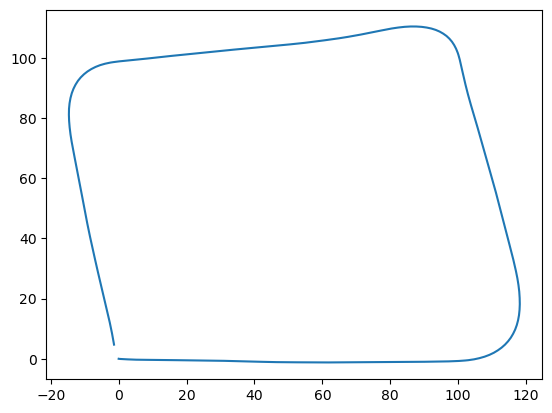

In [8]:
plt.plot(log.x, log.y) # this log should contain all the info you need for a flight

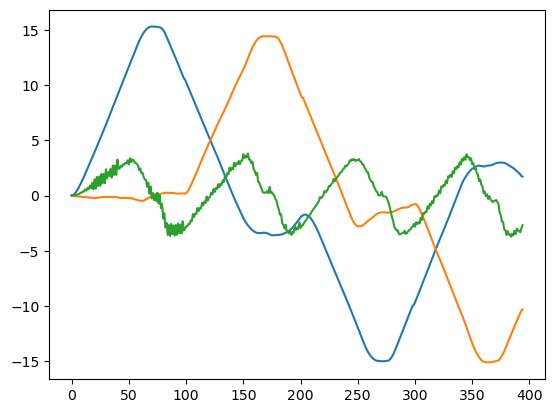

In [9]:
plt.plot(log.velocity)

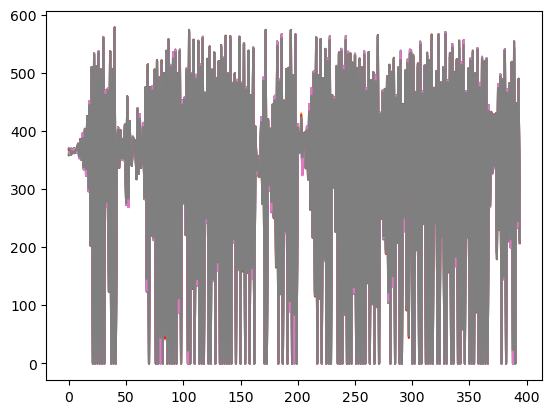

In [10]:
plt.plot(motor_speeds)

In [11]:
info

{'u': array([ 0.,  0., 30.,  0.,  0.,  0.], dtype=float32),
 'dxdt': array([ 1.5130e+00, -1.0709e+01,  2.2700e-01, -1.3830e+00,  2.2700e+00,
        -6.0730e+00,  4.0000e-03,  2.7000e-02,  3.7000e-02, -5.3000e-02,
        -7.2000e-02, -3.3000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=float32),
 'reached': True,
 'outofbounds': False,
 'outoftime': False,
 'tipped': False,
 'crashed': False}

In [12]:
if not info['reached']:
    print('Mission Failed')
else:
    print('Mission Success')

Mission Failed


In [76]:
def addToCSV(log, ms, flight_ID):
    file_name = "wind_flight_data.csv"
    for i in len(log.x):
        new_row = [flight_ID, log.x[i], log.y[i], log.z[i], log.velocity[i][0], log.velocity[i][0], log.velocity[i][0],
                log.roll[i], log.pitch[i], log.yaw[i], ms[0][i], ms[1][i], ms[2][i], ms[3][i], ms[4][i], ms[5][i], ms[6][i], ms[7][i]]

        with open(file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(new_row)

    return 0

In [ ]:
paths = [squareCW, squareCCW, circleCW, circleCCW]
flight_ID = 1

for i in range(len(paths)):
    for wind in range(0, 11):
        for speed in range(3, 13):
            wind_range, wind_vector = sample_wind_range(wind)
            log, info, motor_speeds = run_trajectory(env_selector, wind_range, best_agent, best_params, speed, paths[i])
            if info['reached']:
                addToCSV(log, motor_speeds, flight_ID)
                flight_ID += 1